In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc

sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [3]:
train = pd.read_csv('/kaggle/input/vk-case/train.csv')
attr = pd.read_csv('/kaggle/input/vk-case/attr.csv')

In [4]:
train.head(2)

,ego_id,u,v,t,x1,x2,x3
0,0,131,84,148.0,5.669200e-07,0.0,0.0
1,0,135,164,396.7,6.246274e-02,0.0,0.0


In [5]:
attr.head(2)

,ego_id,u,age,city_id,sex,school,university
0,0,227,68,-1,1,778293348,-1
1,0,45,38,237065842,1,82803468,238500268


In [6]:
print('train info:\n')
print(train.info())

print('\nattr info:\n')
print(attr.info())

train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122280372 entries, 0 to 122280371
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ego_id  int64  
 1   u       int64  
 2   v       int64  
 3   t       float64
 4   x1      float64
 5   x2      float64
 6   x3      float64
dtypes: float64(4), int64(3)
memory usage: 6.4 GB
None

attr info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14930748 entries, 0 to 14930747
Data columns (total 7 columns):
 #   Column      Dtype
---  ------      -----
 0   ego_id      int64
 1   u           int64
 2   age         int64
 3   city_id     int64
 4   sex         int64
 5   school      int64
 6   university  int64
dtypes: int64(7)
memory usage: 797.4 MB
None


In [8]:
attr.describe().T

,count,mean,std,min,25%,50%,75%,max
ego_id,14930748.0,8.545402e+11,4.957422e+11,0.0,4.294967e+11,8.504035e+11,1.288490e+12,1.709397e+12
u,14930748.0,1.168134e+02,7.996565e+01,0.0,4.900000e+01,1.050000e+02,1.760000e+02,2.990000e+02
age,14930748.0,3.274500e+01,1.679906e+01,-1.0,2.100000e+01,3.100000e+01,3.900000e+01,7.890000e+02
city_id,14930748.0,3.216615e+08,3.327196e+08,-1.0,-1.000000e+00,2.236002e+08,6.106148e+08,1.000000e+09
sex,14930748.0,1.441358e+00,4.988081e-01,-1.0,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
school,14930748.0,2.021250e+08,3.063151e+08,-1.0,-1.000000e+00,-1.000000e+00,3.813690e+08,1.000000e+09
university,14930748.0,1.394163e+08,2.711109e+08,-1.0,-1.000000e+00,-1.000000e+00,1.040703e+08,9.999991e+08


Для начала посмотрим на данные.

In [4]:
# Create function to plot regular charts and log charts side by side for numerical columns
def plot_group(df, col_list, sb_method, subplot_dimensions=[10,4], fig_size=(20,20), plot_name='Plot name', transform_=None, **kwargs):
 
  plt.figure(figsize=fig_size)
  
  if transform_ == 'log1p':
      for i, col in enumerate(col_list):
        plt.subplot(*subplot_dimensions, i*2+1)
        sb_method(x=df[col], **kwargs, color='blue').set(title=f"{plot_name} {col}", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
        
        plt.subplot(*subplot_dimensions, i*2+2)
        sb_method(x=df[col].apply('log1p'), **kwargs, color='red').set(title=f"{plot_name} {col} (log1p)", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
    
      plt.show()

  elif transform_ == 'yeo-johnson':
      for i, col in enumerate(col_list):
        plt.subplot(*subplot_dimensions, i*2+1)
        sb_method(x=df[col], **kwargs, color='blue').set(title=f"{plot_name} {col}", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
        
        plt.subplot(*subplot_dimensions, i*2+2)
        sb_method(x=yeojohnson_transform(df, col), **kwargs, color='orange').set(title=f"{plot_name} {col} (yeo-johnson)", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
        
    
    
  elif transform_ == 'both':
      for i, col in enumerate(col_list):
        plt.subplot(*subplot_dimensions, i*3+1)
        sb_method(x=df[col], **kwargs, color='blue').set(title=f"{plot_name} {col}", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
        
        plt.subplot(*subplot_dimensions, i*3+2)
        sb_method(x=df[col].apply('log1p'), **kwargs,  color='red').set(title=f"{plot_name} {col} (log1p)", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        
        
        plt.subplot(*subplot_dimensions, i*3+3)
        sb_method(x=yeojohnson_transform(df, col), **kwargs, color='orange').set(title=f"{plot_name} {col} (yeo-johnson)", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        

  else:
      for i, col in enumerate(col_list):
        plt.subplot(*subplot_dimensions, i+1)
        sb_method(x=df[col], **kwargs).set(title=f"{plot_name} {col}", xlabel = '')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
        
       
      plt.show()

In [5]:
num_features = [*train.select_dtypes(include=np.number).columns]
num_features.remove('x1')
num_features.remove('ego_id')
num_features.append(attr['age'])

In [6]:
cat_features = [*attr.select_dtypes(include=np.number).columns]
cat_features.remove('u')
cat_features.remove('ego_id')

In [ ]:
plot_group(train, num_features, sns.countplot, subplot_dimensions=[15,3], fig_size=(15,65), plot_name='Count plot of ')
plot_group(train, cat_features, sns.countplot, subplot_dimensions=[15,3], fig_size=(15,65), plot_name='Count plot of ')

### -> заменяем NaN на -1 в столбце t

In [17]:
train['t'] = train['t'].fillna(-1)
train.loc[train['t'] == -1]

,ego_id,u,v,t,x1,x2,x3
2,0,47,15,-1.0,0.000000e+00,0.000000,1.0
33,0,233,187,-1.0,0.000000e+00,1.609438,0.0
40,0,280,281,-1.0,0.000000e+00,0.000000,1.0
57,0,166,0,-1.0,3.926171e-05,0.000000,0.0
105,0,243,177,-1.0,1.748604e-08,0.000000,0.0
...,...,...,...,...,...,...,...
122280301,1709396984692,11,0,-1.0,0.000000e+00,1.791759,0.0
122280320,1709396984692,0,7,-1.0,0.000000e+00,1.945910,0.0
122280322,1709396984692,0,18,-1.0,0.000000e+00,2.484907,0.0
122280330,1709396984692,0,11,-1.0,0.000000e+00,1.791759,0.0


### -> Посмотрим на графики распределения величин

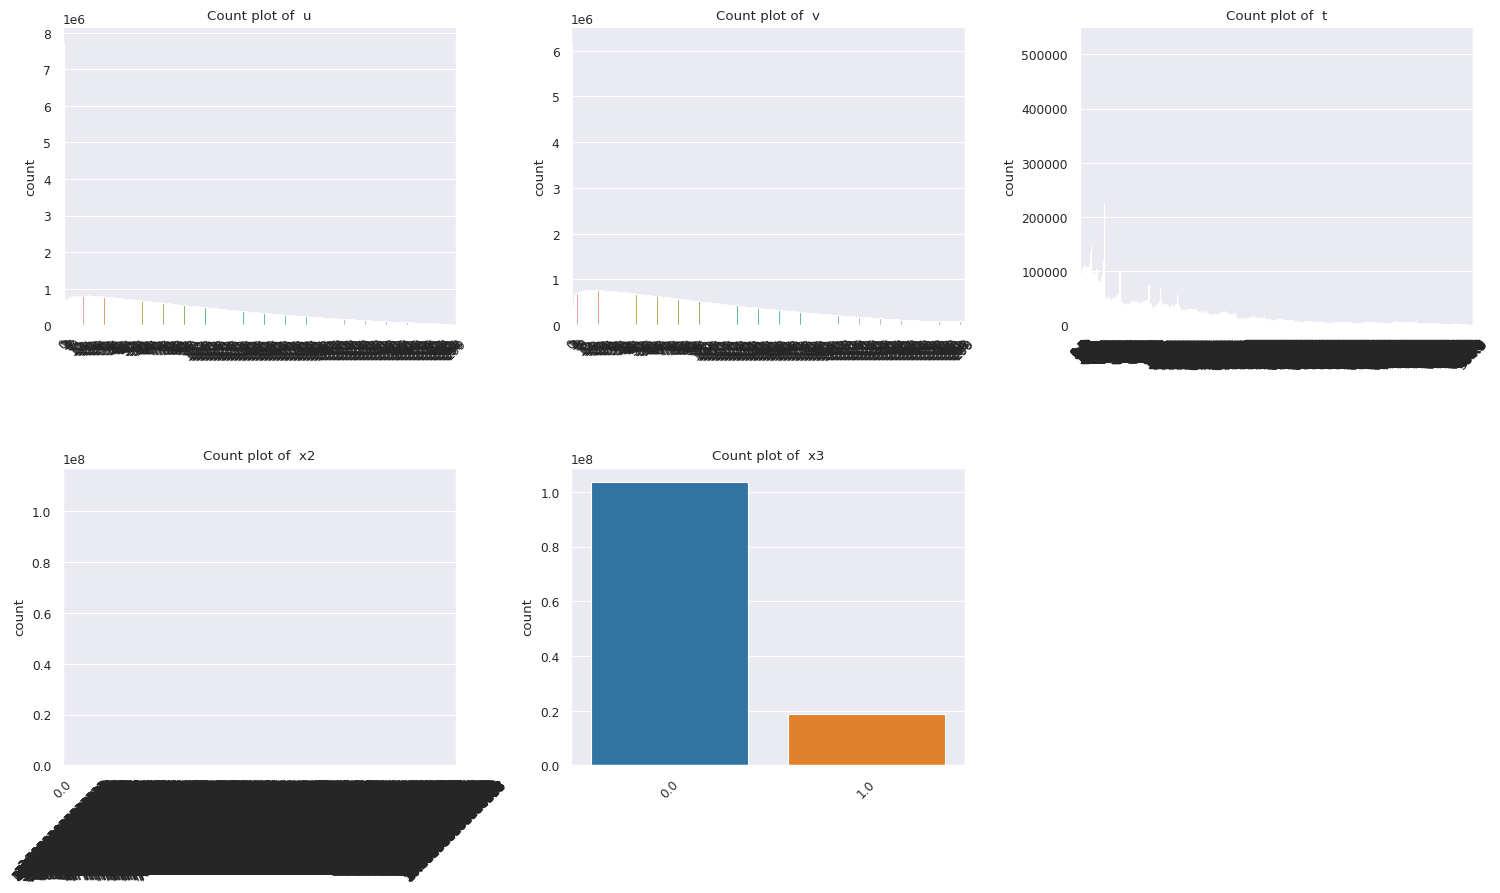

In [13]:
plot_group(train, num_features, sns.countplot, subplot_dimensions=[15,3], fig_size=(15,65), plot_name='Count plot of ')

In [ ]:
# plt.rcParams['figure.figsize'] = (20,15)
# sampled_data.hist()

### -> Посмотрим, есть ли выбросы вы данных возраста

Text(0.5, 1.0, 'Boxplot for age_u')

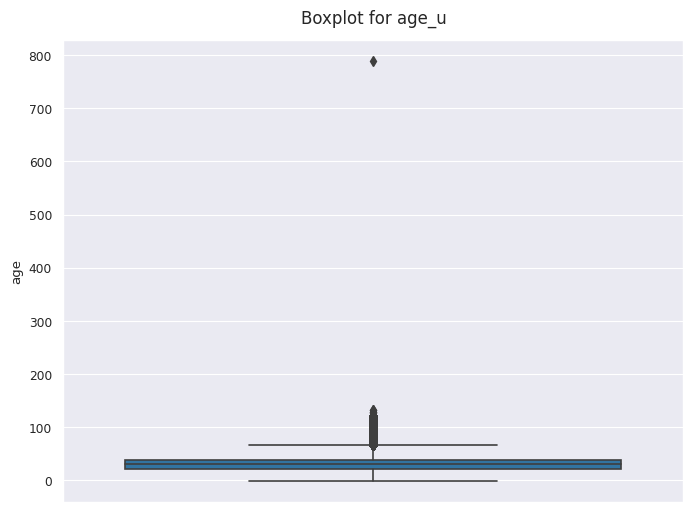

In [14]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(y='age', data=attr)
boxplot.set_title('Boxplot for age_u', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Boxplot for t')

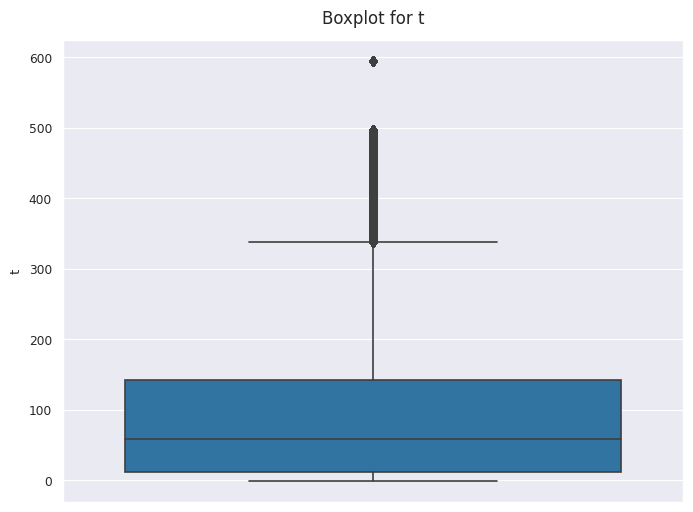

In [22]:
plt.figure(figsize=(8,6))
boxplot = sns.boxplot(y='t', data=train)
boxplot.set_title('Boxplot for t', fontdict={'fontsize':12}, pad=12)